## Loading Data & Preprocessing

In [14]:
# Importing the necesssary libraries.

import pandas as pd
import json
import spacy
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc

In [15]:
# Here,we will be defining the input and output file names.
# Data Source - https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/review_categories

# input_file = 'Baby_Products.jsonl'  
# output_file = 'baby_products.csv'  

# # Here,we are reading the JSON file and have to store each line as a JSON object in a list.
# data = []
# with open(input_file, 'r', encoding = 'utf-8') as f:
#     for line in f:
#         data.append(json.loads(line))

# df = pd.DataFrame(data)
# df.to_csv(output_file, index = False)
# print(f"Conversion is Successful!")

In [35]:
# Defining a function to categorize rating into three classes.

def process_rating(x):
  if x >= 4:
    return "positive"
  if x == 3:
    return "neutral"
  else:
    return "negative"

In [17]:
# We are sampling the data as it is too large!
# And the sampling is done based on our model objective which is prediction of customer sentiments.
# We are using stratified sampling to ensure that the data is representative of the population.
# We took random sample of 40000 instances from each of the three categories of rating.

# df['rating_num'] = df['rating'].apply(process_rating)

# positive_class = df[df['rating_num'] == "positive"]
# neutral_class = df[df['rating_num'] == "neutral"]
# negative_class = df[df['rating_num'] == "negative"]

# sample_positive = positive_class.sample(n=40000, random_state=42)
# sample_neutral = neutral_class.sample(n=40000, random_state=42)
# sample_negative = negative_class.sample(n=40000, random_state=42)

# balanced_sample = pd.concat([sample_positive, sample_neutral, sample_negative])

# balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

# balanced_sample.to_csv('baby_products_rating.csv', index=False)

In [18]:
# This is how our data looks like!

data = pd.read_csv('../data/baby_products_rating.csv')
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,rating_num
0,3.0,Mine didn’t work,The product itself is absolutely beautiful and...,[],B078J37T33,B0BJZXNQVX,AFWZCCQVXPGST4A44WFWKQDGBUEA,1614134627391,0,True,neutral
1,3.0,"After 2 years of use, the cons overcame the pros",We have been using this bed for almost 2 years...,[],B001EQ66WK,B0C674RXLM,AGDWW6FZQJQVOH4J3TEIA3SIL45Q,1458619812000,8,True,neutral
2,3.0,Didn't come with level 1 nipples,Disappointed with Thinkbaby starter kit. It di...,[],B003LPUPWO,B003LPUPWO,AFAEL6HCENBCT5UL5KO7LOHKYFFA,1444835023000,0,True,neutral
3,5.0,Five Stars,excellent!,[],B01BTTM8CS,B01BTTM8CS,AH5FKYMIKQYFSH3DVNABGUEEHQ5Q,1478536981000,0,True,positive
4,5.0,Nice,Very well made :),[],B017OPO4QY,B018552J8M,AGGIBFD3U7QSOORJNVXN36I2UFVA,1605498941233,0,True,positive


In [19]:
df = data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             120000 non-null  float64
 1   title              119987 non-null  object 
 2   text               119974 non-null  object 
 3   images             120000 non-null  object 
 4   asin               120000 non-null  object 
 5   parent_asin        120000 non-null  object 
 6   user_id            120000 non-null  object 
 7   timestamp          120000 non-null  int64  
 8   helpful_vote       120000 non-null  int64  
 9   verified_purchase  120000 non-null  bool   
 10  rating_num         120000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 9.3+ MB


In [20]:
# Dropping the missing values in our data.

df = df.dropna(subset = ['text', 'title'])
df = df[df["rating"] != 0]

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119967 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             119967 non-null  float64
 1   title              119967 non-null  object 
 2   text               119967 non-null  object 
 3   images             119967 non-null  object 
 4   asin               119967 non-null  object 
 5   parent_asin        119967 non-null  object 
 6   user_id            119967 non-null  object 
 7   timestamp          119967 non-null  int64  
 8   helpful_vote       119967 non-null  int64  
 9   verified_purchase  119967 non-null  bool   
 10  rating_num         119967 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 10.2+ MB


## Exploratory Data Analysis (EDA)

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

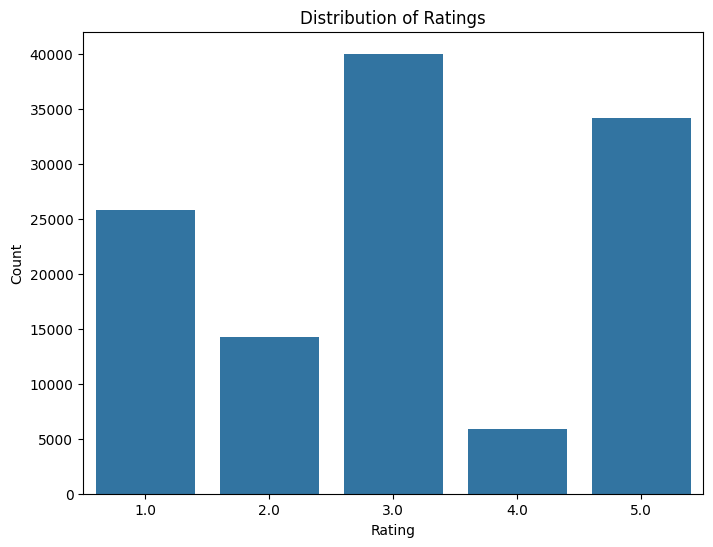

In [23]:
# Bar Chart to show the distribution of Ratings.

rating_counts = df['rating'].value_counts()
plt.figure(figsize = (8, 6))
sns.barplot(x = rating_counts.index, y = rating_counts.values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

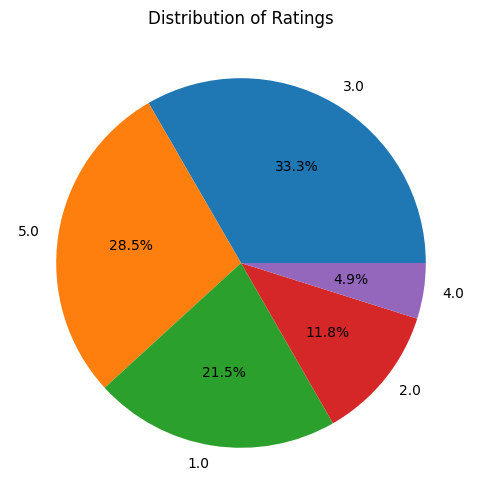

In [24]:
# Pie Chart to show the distribution of Ratings.

rating_counts = rating_counts[rating_counts != 0]
plt.figure(figsize=(8, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.show()

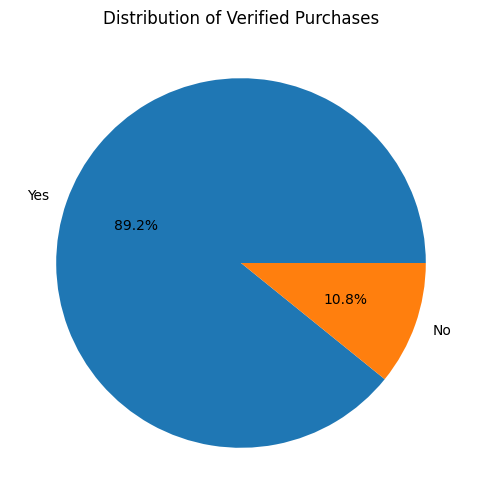

In [25]:
# Pie Chart to show the Distribution of Verified Purchases.

vp_counts = df['verified_purchase'].value_counts()
labels = {True : "Yes",False : "No"}
plt.figure(figsize=(8, 6))
plt.pie(vp_counts, labels=[labels[x] for x in vp_counts.index], autopct='%1.1f%%')
plt.title('Distribution of Verified Purchases')
plt.show()

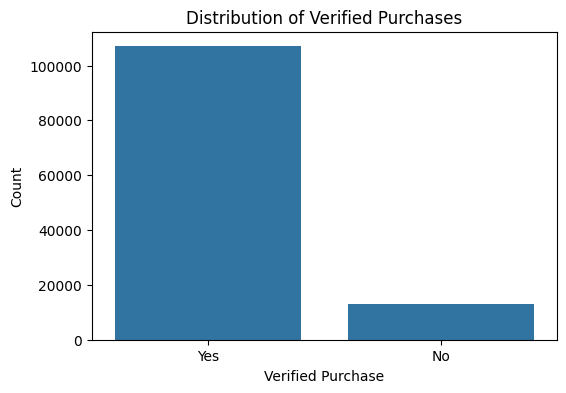

In [26]:
# Bar Chart to show the Distribution of Verified Purchases.

vp_counts = df['verified_purchase'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=[labels[x] for x in vp_counts.index], y=vp_counts.values)
plt.title('Distribution of Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Count')
plt.show()

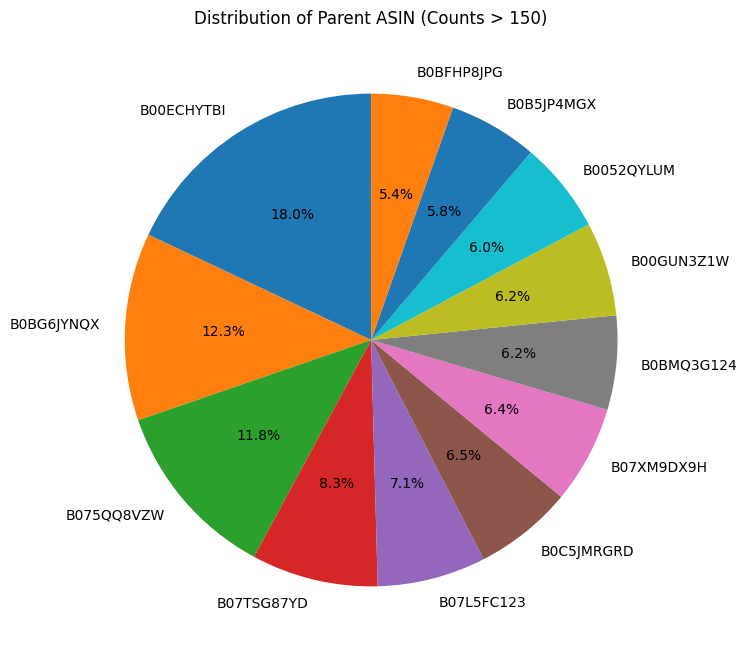

In [27]:
# Pie Chart to show the distribution of Parent ASIN.

# An item can come in a variety of sizes and colors. 
# Each color and size combination is called a variation or child ASIN. 
# The abstraction of the variations is called the Parent ASIN. 

parent_asin_counts = df['parent_asin'].value_counts()

filtered_counts = parent_asin_counts[parent_asin_counts > 150]

plt.figure(figsize=(8, 8))
plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Parent ASIN (Counts > 150)')
plt.show()

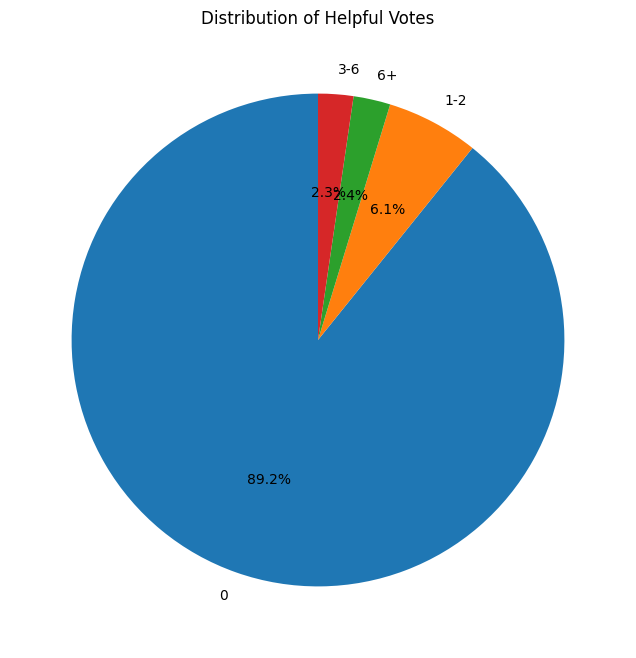

In [28]:
# Pie Chart to show the distribution of Helpful Votes.

bins = [0, 1, 3, 6, float('inf')]
labels = ['0', '1-2', '3-6', '6+']

df['helpful_vote_group'] = pd.cut(df['helpful_vote'], bins=bins, labels=labels, include_lowest=True)

helpful_vote_counts = df['helpful_vote_group'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(helpful_vote_counts, labels=helpful_vote_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Helpful Votes')
plt.show()

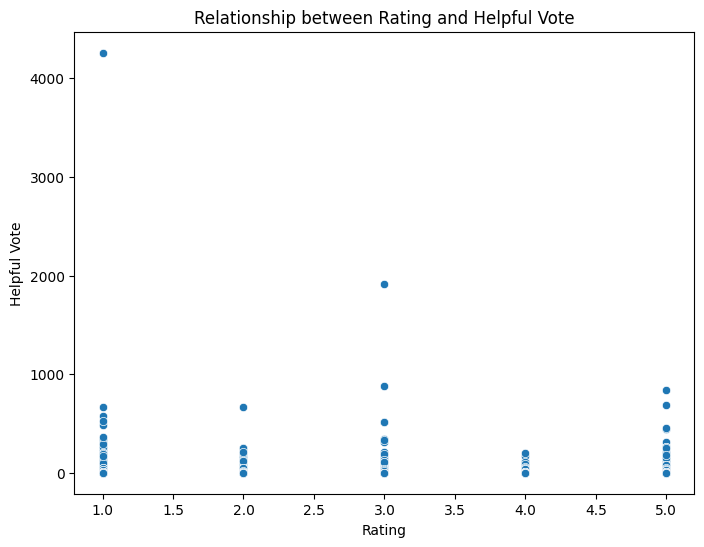

In [29]:
# Scatter Plot to show the relationship between Rating and Helpful Votes.

plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='helpful_vote', data=df)
plt.title('Relationship between Rating and Helpful Vote')
plt.xlabel('Rating')
plt.ylabel('Helpful Vote')
plt.show()

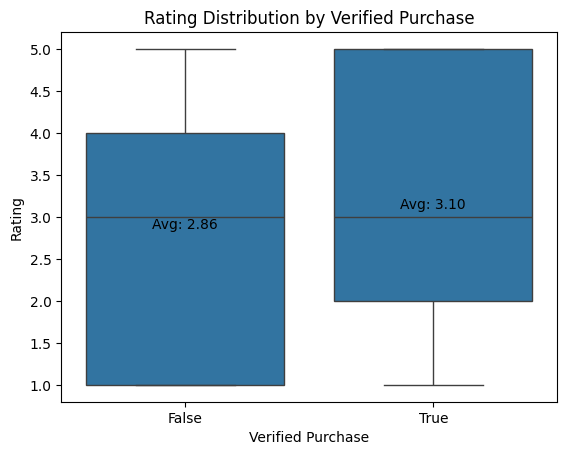

In [30]:
# Below Boxplot is used to depict Rating Distribution by Verified Purchases.

average_ratings = df.groupby('verified_purchase')['rating'].mean()

sns.boxplot(x='verified_purchase', y='rating', data=df)

for i, avg_rating in enumerate(average_ratings):
    plt.text(i, avg_rating, f'Avg: {avg_rating:.2f}', ha='center')

plt.xlabel('Verified Purchase')
plt.ylabel('Rating')
plt.title('Rating Distribution by Verified Purchase')
plt.show()

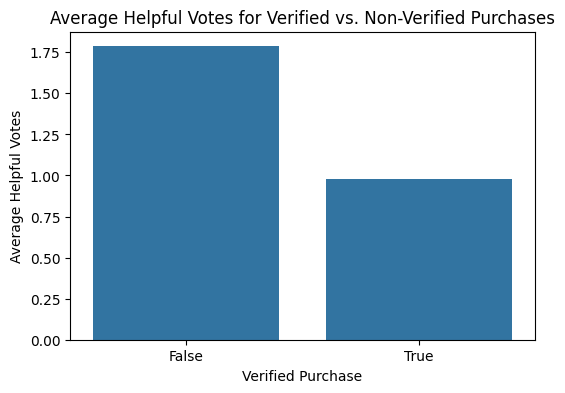

In [31]:
# Bar Chart to show the Average Helpful Votes for Verified vs. Non-Verified Purchases.

verified_helpful_votes = df.groupby('verified_purchase')['helpful_vote'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='verified_purchase', y='helpful_vote', data=verified_helpful_votes)
plt.title('Average Helpful Votes for Verified vs. Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Average Helpful Votes')
plt.show()


## Model Building

In [32]:
# Creating a new feature by combining the title and text attributes.
# This combined feature will be used for the prediction.

df['title_text'] = df['title'] + " " + df["text"]

In [36]:
# Encoding the classes into numerical values.

df["rating"] = df["rating"].apply(process_rating)

def encode_rating(x):
    if x == "negative":
        return 0
    if x == "neutral":
        return 1
    if x == "positive":
        return 2

In [37]:
df["rating"] = df["rating"].apply(encode_rating)

In [38]:
df.rating.value_counts()

rating
1    39994
0    39991
2    39982
Name: count, dtype: int64

In [39]:
# We will use the NLP library spacy to tokenize and lemmatize(group together) the text.

nlp = spacy.load('en_core_web_lg')

def process_text(x):
    doc = nlp(x)
    filtered_tokens = []
    for token in doc:
        if token.is_punct:   
            continue
        filtered_tokens.append(token.lemma_)  
    return " ".join(filtered_tokens)


In [40]:
df['title_text'] = df['title_text'].apply(process_text)

In [41]:
# Data split into train and test sets.(80:10:10)

X_train, X_test,y_train, y_test = train_test_split(df['title_text'], df['rating'],
                                                    test_size = 0.2, random_state = 2024)

## Naive Bayes Classifier

In [42]:
# Here, we are generating a pipeline for developing Naive Bayes Classifier.
pipe = Pipeline([('tfidf', TfidfVectorizer()) ,                                           
                 ('classifier', MultinomialNB())])

param_dist = {
    'tfidf__max_df': np.linspace(0.7, 1.0, 10),
    'tfidf__min_df': np.arange(1, 10),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],       
    'tfidf__smooth_idf': [True, False],                 
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2', None], 
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'classifier__fit_prior': [True, False],
}

nb_classifier = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                   verbose=1, random_state=2024)

nb_classifier.fit(X_train, y_train)
print("Best hyperparameters: ", nb_classifier.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 3, 'tfidf__max_df': 0.7666666666666666, 'classifier__fit_prior': False, 'classifier__alpha': 0.01}


In [43]:
# Classification Report on Train and Test sets.

y_pred_train = nb_classifier.best_estimator_.predict(X_train)
print("Classification report for train data. \n", classification_report(y_train, y_pred_train))

y_pred_test = nb_classifier.best_estimator_.predict(X_test)
print("Classification report for test data. \n", classification_report(y_test, y_pred_test))

Classification report for train data. 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     31947
           1       0.88      0.91      0.90     31950
           2       0.97      0.93      0.95     32076

    accuracy                           0.92     95973
   macro avg       0.92      0.92      0.92     95973
weighted avg       0.92      0.92      0.92     95973

Classification report for test data. 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      8044
           1       0.65      0.73      0.69      8044
           2       0.92      0.83      0.87      7906

    accuracy                           0.77     23994
   macro avg       0.78      0.77      0.77     23994
weighted avg       0.78      0.77      0.77     23994



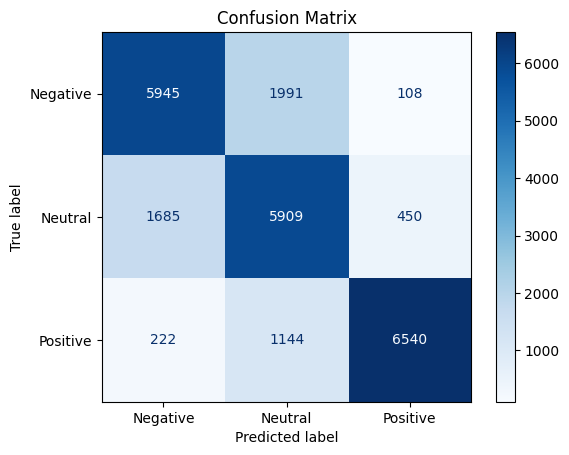

In [44]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Here, negative = 0,neutral = 1 and positive = 2 based on the encoding done previously.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

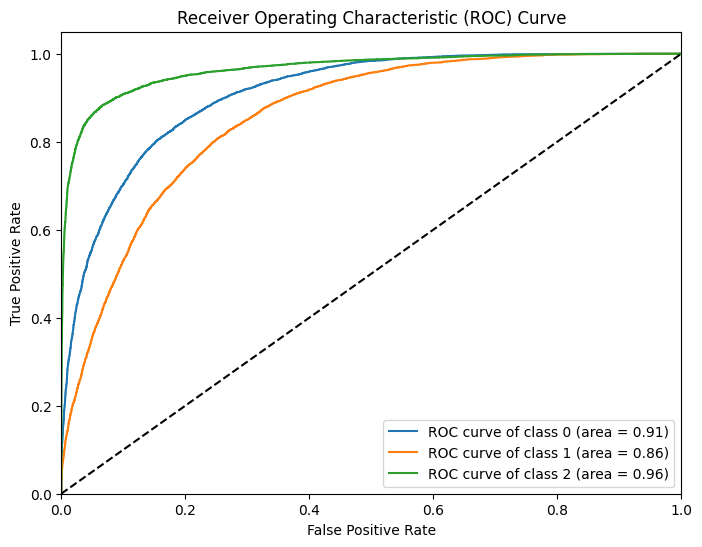

In [45]:
y_probs = nb_classifier.best_estimator_.predict_proba(X_test)

# Here, we are calculating ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
import pickle
import os

# Create models directory if not exists
os.makedirs("../models", exist_ok=True)

# Save Naive Bayes model.
with open("../models/naive_bayes.pkl", "wb") as f:
    pickle.dump(nb_classifier, f)


print("✅ Model exported successfully to 'models/' directory.")

✅ Model exported successfully to 'models/' directory.
